In [1]:
import os
import random
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [2]:
BACKBONE_3 = 'resnet152'
preprocessing_input = sm.get_preprocessing(BACKBONE_3)

In [3]:
seed=24                   # setting seed 
batch_size= 4           # batch_size for training
n_classes= 1 # number of class/ labels in the dataset

In [4]:
# data normalization
scaler = MinMaxScaler()

In [5]:
# preprocessing the input images
def data_preprocessing(img, mask, num_class):
    
    #Scale images  
    #img = img[0:512,0:512]
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)   # fit and transform image using MinMaxScaler
    
    # preprocessing the input if a backbone is used else comment the line below if you want to use just UNET
    img = preprocessing_input(img)
    
    #mask = mask[0:512,0:512]
    # label encoding for the mask image
    labelencoder = LabelEncoder()                                                   # initializing Labelencoder
    number_of_images, height, width, channles= mask.shape                           # shape of the mask image
    mask_reshape = mask.reshape(-1,1)                                               # reshaping the mask image numpy array
    encoded_mask = labelencoder.fit_transform(mask_reshape.ravel())                 # fit and transform mask image using label encoder
    original_encoded_mask = encoded_mask.reshape(number_of_images, height, width )  # reshaping the image numpy array
    mask = np.expand_dims(original_encoded_mask, axis = 3)                          # expanding dimension (requirement by the model)
                                                                    
    #Convert mask to one-hot encoding
    #mask = to_categorical(mask, num_class)
                                        # into to categorical pixel values
    return (img,mask)

In [6]:
# defining the data loader
def TFDataLoader(train_img_path, train_mask_path, num_class):
    
    # augmention parameters for images
    img_data_gen_args = dict(
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest'
                      )

    # initializing ImageDataGenerator for both images and masks
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    # images will be loaded directly from the local drive (less load on the memory)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        target_size=(128, 128),     # for PSP net ,shape should be divisible by 48
        class_mode = None,
        color_mode = "rgb",
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        target_size=(128, 128),
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
        
    # zip both images and mask 
    data_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in data_generator:
        img, mask = data_preprocessing(img, mask, num_class)
        # mask = mask[:,:,:,1:] # to remove background!
        yield (img, mask)

In [7]:
train_img_path = "./data/train/"                    
train_mask_path = "./data/train_label/"
train_img_gen = TFDataLoader(train_img_path, train_mask_path, num_class=1)   

val_img_path = "./data/val/"
val_mask_path = "./data/val_label/"
val_img_gen = TFDataLoader(val_img_path, val_mask_path, num_class=1)  

In [8]:
x_train, y_train = train_img_gen.__next__() # data iterator

Found 3075 images belonging to 1 classes.
Found 3075 images belonging to 1 classes.


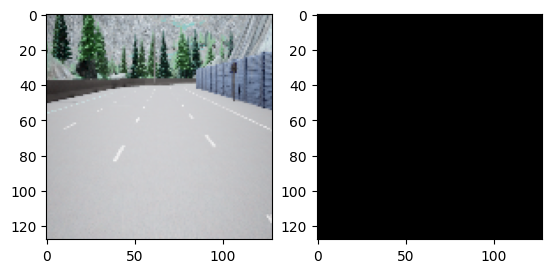

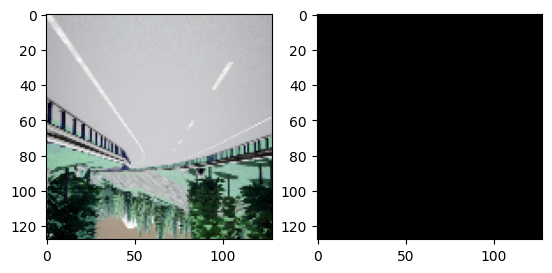

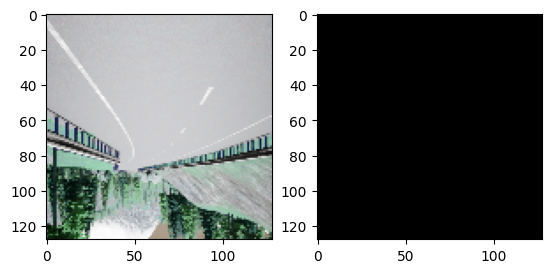

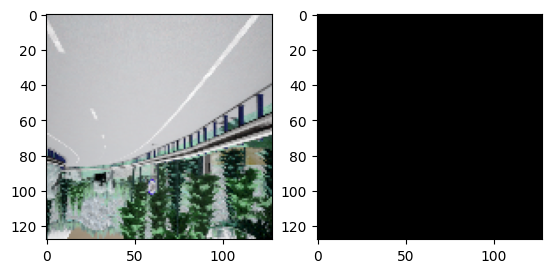

In [9]:
x_train, y_train = train_img_gen.__next__() # data iterator

# checking/ verifying if the image and masks are coorelated
for i in range(0,4):
    image = x_train[i]
    mask = np.argmax(y_train[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap = 'gray' ) 
    plt.show()
    

Found 129 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


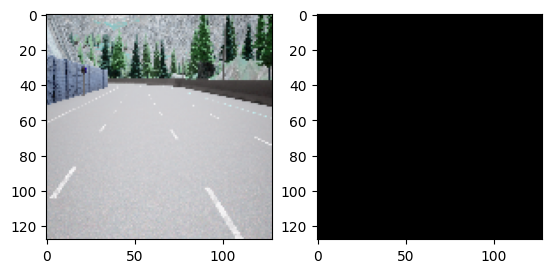

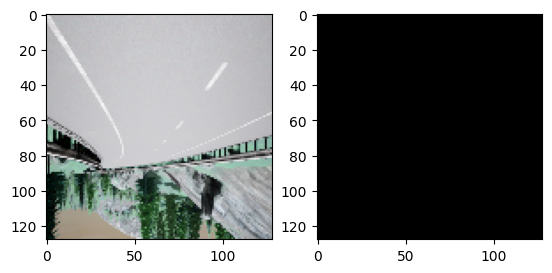

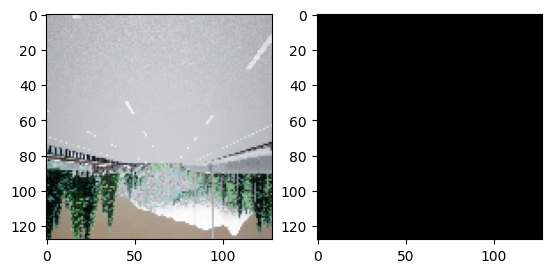

In [10]:
x_val, y_val = val_img_gen.__next__()
for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [11]:
# inputs for the UNET model
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]
print(IMG_CHANNELS)

3


In [12]:
# defining the loss function:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss(gamma=3)
total_loss = dice_loss + (1*focal_loss)

metrics = [sm.metrics.IOUScore(threshold = 0.5), sm.metrics.FScore(threshold = 0.5),'accuracy']

In [13]:
keras.backend.clear_session()

In [14]:
# for scale.rapid
train_img_path_len = "./data/train/Lanes/"
img_list_len = len(os.listdir(train_img_path_len))
print(img_list_len)

# for cvat
# train_img_path_len = "../../data/unet_img/Data_TF_397/train_image/JPEGImages"
# img_list_len = len(os.listdir(train_img_path_len))
# print(img_list_len)

3075


In [15]:
# input for the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# model intializing (using UNET from Segmentation model lib)    #n_classes
model_3 = sm.Unet(BACKBONE_3, 
                encoder_weights = 'imagenet', 
                input_shape = input_shape, 
                classes = 1 ,
                activation = 'sigmoid')
learning_rate = 1e-4
#model_3.trainable = False

# loading weights:
#model_3.load_weights('UNET_RESNET152_ScaleRapid_08Jun22.hdf5')
model_3.compile(optimizer = Adam(learning_rate = learning_rate),
                loss = total_loss, 
                metrics = metrics)
#model_3.summary()

In [16]:
#Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#Visualize on tensorboard (move this above)
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19192), started 0:06:59 ago. (Use '!kill 19192' to kill it.)

In [17]:
%reload_ext tensorboard

In [18]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('PSP_RESNET152_ScaleRapid__.hdf5', monitor='loss',verbose=1)

In [19]:
# model fitting
steps_per_epoch = img_list_len //batch_size
history_3 = model_3.fit(train_img_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs = 10,
                    validation_data=val_img_gen, 
                    validation_steps=steps_per_epoch,
                    verbose = 1, callbacks = [model_checkpoint, tensorboard_callback] )

Epoch 1/10


TypeError: in user code:

    File "c:\Users\harry\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\harry\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models\base\objects.py", line 114, in __call__  *
        return self.l1(gt, pr) + self.l2(gt, pr)
    File "c:\Users\harry\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models\losses.py", line 104, in __call__  *
        **self.submodules
    File "c:\Users\harry\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models\base\functional.py", line 145, in f_score  *
        tp = backend.sum(gt * pr, axis=axes)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.
